### Task 1: Tabular Q-Learning Update

In [6]:
import numpy as np
def init_q_table(n_states, n_actions):
    table = np.zeros((n_states,n_actions))
    return table

def q_update(Q,s,a,r,s_next,lr,df):
    Q[s,a] = Q[s,a] + lr(r + df*np.max(Q[s_next]) - Q[s,a])
    return Q

### Task 2: ε-Greedy Policy on a Custom GridWorld

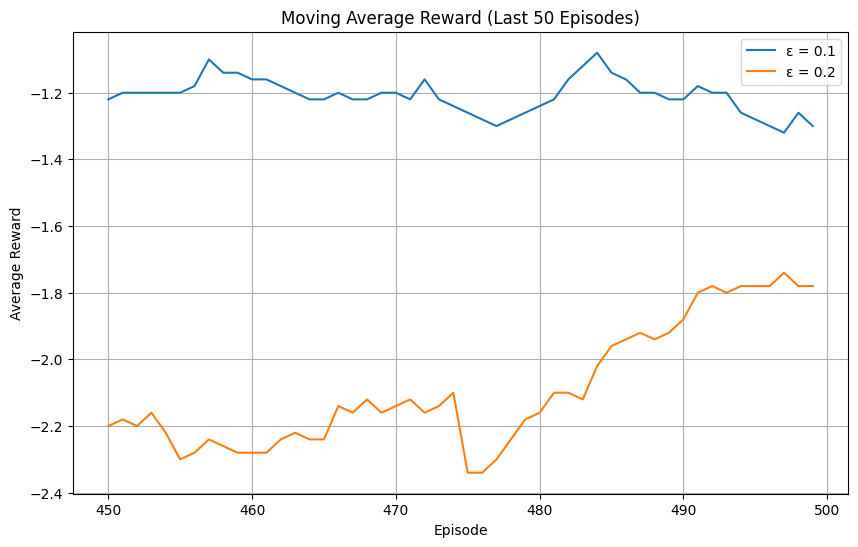

In [12]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, size=4):
        self.size = size
        self.terminal_positions = [(0, 0), (size - 1, size - 1)]
        self.action_space = 4  

    def reset(self):
        while True:
            row = np.random.randint(self.size)
            col = np.random.randint(self.size)
            if (row, col) not in self.terminal_positions:
                break
        self.pos = (row, col)
        return self.pos

    def step(self, action):
        row, col = self.pos

        if (row, col) in self.terminal_positions:
            return (row, col), 0, True

        if action == 0 and row > 0:
            row -= 1  
        elif action == 1 and row < self.size - 1:
            row += 1  
        elif action == 2 and col > 0:
            col -= 1  
        elif action == 3 and col < self.size - 1:
            col += 1  

        self.pos = (row, col)
        reward = 0 if self.pos in self.terminal_positions else -1
        done = self.pos in self.terminal_positions
        return self.pos, reward, done

def select_action(Q, state, ε):
    row, col = state
    if np.random.rand() < ε:
        return np.random.randint(Q.shape[2])
    else:
        return np.argmax(Q[row, col])

def q_update(Q, s, a, r, s_next, α, γ):
    row, col = s
    next_row, next_col = s_next
    Q[row, col, a] += α * (r + γ * np.max(Q[next_row, next_col]) - Q[row, col, a])
    return Q

def train_agent(epsilon, episodes=500):
    env = GridWorld()
    Q = np.zeros((env.size, env.size, env.action_space))
    lr = 0.1  
    df = 0.95 
    rewards = []

    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = select_action(Q, state, epsilon)
            next_state, reward, done = env.step(action)
            Q = q_update(Q, state, action, reward, next_state, lr, df)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

    return rewards

def plot_results(rewards_01, rewards_02):
    def moving_average(data, window_size=50):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(10, 6))
    plt.plot(range(450, 500), moving_average(rewards_01)[-50:], label='ε = 0.1')
    plt.plot(range(450, 500), moving_average(rewards_02)[-50:], label='ε = 0.2')
    plt.title('Moving Average Reward (Last 50 Episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

rewards_e01 = train_agent(0.1)
rewards_e02 = train_agent(0.2)

plot_results(rewards_e01, rewards_e02)


Due to the high reward of the terminal cell, the epsilon=0.2 suffers in comparison to the epsilon=0.1 as it explores more rather than sticking to an optimal path to get the reward. However, it may benefit in the future as it seems to grow while the epsilon=0.1 seems to stabilize.

### Task 3: Experience Replay Buffer

In [14]:
import numpy as np
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (np.array(states),
                np.array(actions),
                np.array(rewards, dtype=np.float32),
                np.array(next_states),
                np.array(dones, dtype=bool))

    def __len__(self):
        return len(self.buffer)

buffer = ReplayBuffer(capacity=100)

for _ in range(100):
    state = np.random.randint(0, 16)
    action = np.random.randint(0, 4)
    reward = np.random.uniform(-1.0, 1.0)
    next_state = np.random.randint(0, 16)
    done = np.random.choice([True, False])
    buffer.push(state, action, reward, next_state, done)

batch_size = 32
states, actions, rewards, next_states, dones = buffer.sample(batch_size)

print("Shapes:")
print(f"States: {states.shape}, Actions: {actions.shape}, Rewards: {rewards.shape}, Next States: {next_states.shape}, Dones: {dones.shape}")

print("Data Types:")
print(f"States: {states.dtype}, Actions: {actions.dtype}, Rewards: {rewards.dtype}, Next States: {next_states.dtype}, Dones: {dones.dtype}")



Shapes:
States: (32,), Actions: (32,), Rewards: (32,), Next States: (32,), Dones: (32,)
Data Types:
States: int32, Actions: int32, Rewards: float32, Next States: int32, Dones: bool


### Task 4: Deep Q-Network with Target Copy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQNPolicy(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DQNPolicy, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

class DQNTarget(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super(DQNTarget, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

### Task 5: Full DQN Training Loop on CartPole-v1

Episode   3 | Avg Reward (last 100): 12.00 | Success Rate: 0.0%
Episode   6 | Avg Reward (last 100): 18.67 | Success Rate: 0.0%
Episode   9 | Avg Reward (last 100): 18.33 | Success Rate: 0.0%
Episode  12 | Avg Reward (last 100): 17.17 | Success Rate: 0.0%
Episode  15 | Avg Reward (last 100): 18.93 | Success Rate: 0.0%
Episode  18 | Avg Reward (last 100): 18.22 | Success Rate: 0.0%
Episode  21 | Avg Reward (last 100): 20.10 | Success Rate: 0.0%
Episode  24 | Avg Reward (last 100): 20.17 | Success Rate: 0.0%
Episode  27 | Avg Reward (last 100): 19.22 | Success Rate: 0.0%
Episode  30 | Avg Reward (last 100): 18.93 | Success Rate: 0.0%
Episode  33 | Avg Reward (last 100): 19.73 | Success Rate: 0.0%
Episode  36 | Avg Reward (last 100): 20.19 | Success Rate: 0.0%
Episode  39 | Avg Reward (last 100): 20.44 | Success Rate: 0.0%
Episode  42 | Avg Reward (last 100): 20.86 | Success Rate: 0.0%
Episode  45 | Avg Reward (last 100): 21.13 | Success Rate: 0.0%
Episode  48 | Avg Reward (last 100): 21.

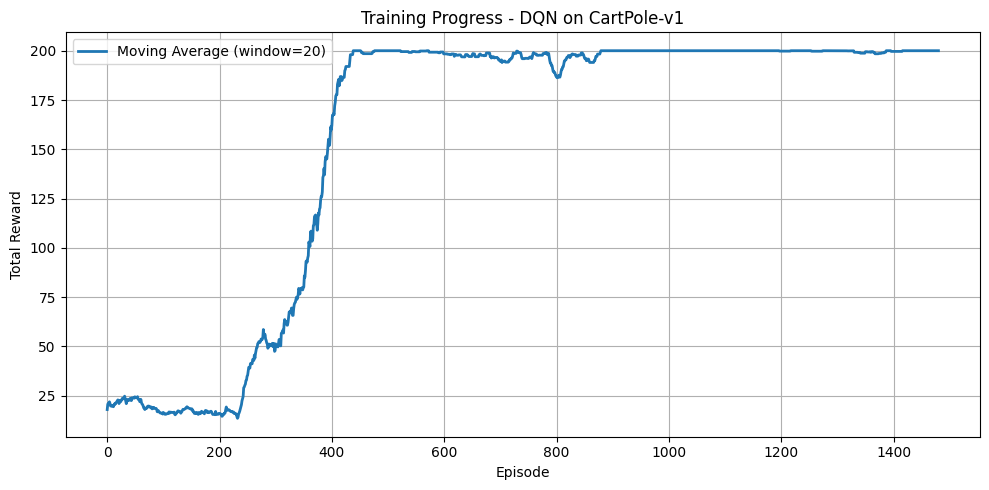


Final Success Rate: 68.27% (1024 out of 1500 episodes)


In [7]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(DQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
       
        self.to(device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
        self.seed = random.seed(seed)
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)
    
class DQNAgent:
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)


        self.qnetwork_local = DQN(state_size, action_size, seed).to(device)
        self.qnetwork_target = DQN(state_size, action_size, seed).to(device)


        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)
        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > 64:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    def act(self, state, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)
        
    def update_target(self):
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

N = 1500
M = 0.0020
X = 3

max_steps = 200
epsilon_start = 1.0
epsilon_end = 0.01
learning_rate = 0.00025
gamma = 0.99

agent = DQNAgent(state_size=state_dim, action_size=action_dim, seed=170715, lr=learning_rate)

episode_rewards = []
success_count = 0

def moving_average(data, window=20):
    return np.convolve(data, np.ones(window) / window, mode='valid')

for episode in range(N):
    state, _ = env.reset()
    epsilon = max(epsilon_end, epsilon_start - M * episode)
    total_reward = 0

    for _ in range(max_steps):
        action = agent.act(state, eps=epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.step(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward
        if done:
            break

    episode_rewards.append(total_reward)

    if total_reward >= 195:
        success_count += 1

    if (episode + 1) % X == 0:
        agent.update_target() 
        avg_reward = np.mean(episode_rewards[-100:])
        success_rate = (success_count / (episode + 1)) * 100
        print(f"Episode {episode + 1:>3} | Avg Reward (last 100): {avg_reward:.2f} | Success Rate: {success_rate:.1f}%")

plt.figure(figsize=(10, 5))
plt.plot(moving_average(episode_rewards), label="Moving Average (window=20)", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress - DQN on CartPole-v1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

final_success_rate = (success_count / N) * 100
print(f"\nFinal Success Rate: {final_success_rate:.2f}% ({success_count} out of {N} episodes)")